# PA005: High Value Customer Identification

Na cor preta: o que foi desenvolvido no ciclo. 


Na cor vermelha: o que não foi desenvolvido no ciclo ou que foi feito o mínimo necessário para gerar um resultado inicial no projeto.

# 0.0 Imports

In [1]:
# Biblioteca para manipulação dos dataframes
import pandas   as pd 
import re
# Biblioteca para trabalhar com vetores e arrays
import numpy    as np

# Bibliotecas para trabalhar com Gráficos
import seaborn  as sns
from matplotlib import pyplot  as plt 
from plotly import express as px 

# Biblioteca para configurar layout tela Jupyter
from IPython.core.display import HTML

# Biblioteca para alterar nome das colunas de Kamel Case para Snake Case
import inflection

# Biblioteca para implementar e avaliar algoritmos 
from sklearn import cluster as ct
from sklearn import metrics as mt
from sklearn import preprocessing as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import plotly.graph_objs as go

# Biblioteca para redução de dimensionalidade dos dados
import umap.umap_ as umap

C:\Users\alanc\anaconda3\envs\insiders_clustering\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\alanc\anaconda3\envs\insiders_clustering\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\alanc\anaconda3\envs\insiders_clustering\lib\site-pac

## 0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:97% !important; }</style>') )
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = 50
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    return None

jupyter_settings()

## 0.2 Load Dataset

In [3]:
# load data
df_raw = pd.read_csv('C:/Users/alanc/Documents/repos/insiders_clustering/data/raw/ecommerce.csv', encoding = 'unicode_escape' )

# drop extra column
df_raw.drop(columns = ['Unnamed: 8'], inplace = True)

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.390,17850.000,United Kingdom


#  1.0 Descrição dos dados 

In [5]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df1 = df_raw.copy()

## 1.1. Rename Columns

Ter o nome das colunas de maneira mais intuitiva para trabalhar com ciência de dados

In [27]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
            'UnitPrice', 'CustomerID', 'Country']

## Utiliza função lambda para encapsular a função que transforma para snake_case os atributos
snakecase = lambda x: inflection.underscore( x )

## Map - Mapeia cada valor dentro da estrutura de dado passada e aplica a função snakecase
cols_new = list( map( snakecase, cols_old ) )

## rename 
df1.columns = cols_new

In [7]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.2 Columns Meanings

Objetivo é compreender o significado de cada coluna 

- **invoice_no:** identificador único de cada transação;


- **stock_code:** código do item;


- **description:** nome do item;


- **quantity:** quantidade de cada item comprado por transação;	


- **invoice_data:** data em que a transação ocorreu;


- **unit_price:** preço unitário do produto;


- **customer_id:** identificador único do cliente;


- **country:** país que o cliente reside.

## 1.3. Data Dimensions

Analisar a dimensão dos dados a serem trabalhados

In [30]:
print(f"Número de linhas: {df1.shape[0]}")
print(f"Número de colunas: {df1.shape[1]}")

Número de linhas: 541909
Número de colunas: 8


## 1.4. Data Types

Verificar se os tipos de dados correspondem corretamente a informação que as colunas estão apresentando 

In [31]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.5. Check NA

Verificar a existência de valores nulos 

In [37]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## <font color = 'red'> 1.6.  Fillout NA </font>

Tratar os valores nulos  

In [8]:
## Tratar da maneira mais simples primeiramente -> remover na
df1.dropna( subset = ['description','customer_id'], inplace = True )

print("Dados Removidos: {:.2f}%".format( (1 - (df1.shape[0]/df_raw.shape[0]) )*100  ) )

Dados Removidos: 24.93%


In [9]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.7. Change Data Types

 

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [10]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.390,17850.000,United Kingdom


In [10]:
# arrumar coluna para ficar com tipo de dado de date 
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# passar coluna de float64 -> int64, não tem necessidade de ser float 
df1['customer_id'] = df1['customer_id'].astype('int64')

In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [13]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.550,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.390,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.750,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.390,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.390,17850,United Kingdom


##  1.8. Descriptive Statistical 


Resumo Geral dos dados com o objetivo de compreender comportamento , outliers e anormalidades nos valores dos atributos.

In [14]:
num_attributes = df1.select_dtypes( include = ['int64','float64'])
cat_attributes = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'])

### 1.8.1. Numerical Attributes

In [13]:
# OPTION 1

# Central Tendency - mean, median

# ct1 = pd.DataFrame( num_attributes.apply( np.mean ) )
# ct2 = pd.DataFrame( num_attributes.apply( np.median ) )
# 
# # Dispersion - std, min, max, range, skew, kurtosis
# d1 = pd.DataFrame( num_attributes.apply( np.std ) )
# d2 = pd.DataFrame( num_attributes.apply( min ) )
# d3 = pd.DataFrame( num_attributes.apply( max ) )
# d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) )
# d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) )
# d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) )
# 
# m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6], axis = 1 ).reset_index()
# 
# m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']

# OPTION  2

## Min, Max, Range, Mean, Median, Std, Skew, Kurtosis
num_attributes.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes', 'ptp': 'range'})

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.000,80995.000,161990.000,12.061,5.000,248.693,0.183,94317.564
1,unit_price,0.000,38970.000,38970.000,3.460,1.950,69.315,452.219,246924.543
2,customer_id,12346.000,18287.000,5941.000,15287.691,15152.000,1713.600,0.030,-1.180


Investigar:
    
1. Quantidade negativa de produtos; ( hipótese que possa ser devolução )
2. Quantidade muito elevada (max quantity) de um único produto em uma transação; (hipótese de outlier)
3. Preço unitário de produto igual a 0;(brindes ou promoções?)
4. Máximo Preço unitário de produto. (hipótese de outlier)

### 1.8.2. Categorical Attributes

In [14]:
# Quantidade Valores únicos de cada uma das categorias 

print(f"Quantidade de valores únicos em cada atributo: \n { cat_attributes.apply( lambda x: x.nunique() ) } \n")
print(f"Valores únicos em cada atributo: \n { cat_attributes.apply( lambda x: x.unique() ) } \n")

Quantidade de valores únicos em cada atributo: 
 invoice_no     22190
stock_code      3684
description     3896
country           37
dtype: int64 

Valores únicos em cada atributo: 
 invoice_no     [536365, 536366, 536367, 536368, 536369, 53637...
stock_code     [85123A, 71053, 84406B, 84029G, 84029E, 22752,...
description    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
country        [United Kingdom, France, Australia, Netherland...
dtype: object 



In [15]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


Investigar:
    
1. Códigos de transação (invoice_no) com letras e números e outros apenas com números; 
2. Verificar porque nº únicos de stock_code está diferente do description;
3. Países que estão no conjunto de dados existem de fato.

#### invoice_no

In [18]:
df_let_invoice = df1.loc[ df1['invoice_no'].apply(lambda x: bool( re.search('[^0-9]+', x) ) ), :] 

df_let_invoice['quantity'].max()

-1

**Conclusão:**

Todos os registros de quantidades de produtos em que o código da transação possui caracter diferente de números são descontados (negativos). 

In [16]:
### INVOICE_NO

## Variável condicional para encontrar nos valores da coluna 'invoice_no' se existe um caracter diferente de numérico
val_c = cat_attributes['invoice_no'].apply(lambda x: bool( re.search('[^0-9]+', x) ) )

## Quantidade de valores únicos com código de transação com a letra C
cat_attributes.loc[ val_c , 'invoice_no'].nunique()

3654

In [54]:
# Valores únicos com código de transação contendo letras
cat_attributes.loc[ val_c , 'invoice_no'].unique()

array(['C536379', 'C536383', 'C536391', ..., 'C581499', 'C581568',
       'C581569'], dtype=object)

In [55]:
## Variável condicional para encontrar apenas valores da coluna 'invoice_no' contendo uma letra
let_in = cat_attributes['invoice_no'].apply(lambda x: bool( re.search('^[a-zA-Z]$', x) ) )
 
cat_attributes.loc[let_in, 'invoice_no'].unique()

array([], dtype=object)

Não possui código de transação com uma letra apenas

In [59]:
## Variável condicional para encontrar apenas valores da coluna 'invoice_no' contendo letras
let_inf = cat_attributes['invoice_no'].apply(lambda x: bool( re.search('[a-zA-Z]^', x) ) )

cat_attributes.loc[let_inf, 'invoice_no'].unique()

array([], dtype=object)

**Conclusão:** Para código de transações existem alguns que são apenas números que são as retiradas (saídas/compras) e as devoluções com a letra C na frente de um outro número representando o cancelamento. 

- Dos 22.190 registros de transações existentes, 3.654 são de devoluções.

#### stock_code

In [ ]:
## Variável condicional para encontrar nos valores da coluna 'stock_code' digitos além de números
let = cat_attributes['stock_code'].apply(lambda x: bool( re.search('[^0-9]+', x) ) )

In [31]:
## Valores com código de produto contendo letras
cat_attributes.loc[ let , 'stock_code']

0         85123A
2         84406B
3         84029G
4         84029E
45          POST
           ...  
541778    84997C
541809    85099C
541838    84993A
541844    85049A
541853    85049E
Name: stock_code, Length: 35809, dtype: object

In [30]:
## Quantidade de valores únicos com código de produto que possuam letras
cat_attributes.loc[ let , 'stock_code'].nunique()

886

In [60]:
## Valores únicos com código de produto que possuam letras
cat_attributes.loc[ let , 'stock_code'].unique()

array(['85123A', '84406B', '84029G', '84029E', 'POST', '82494L', '85099C',
       '84997B', '84997C', '84519A', '85183B', '85071B', '37444A',
       '37444C', '84971S', '15056BL', '15056N', 'D', '35004C', '85049A',
       '85099B', '35004G', '85014B', '85014A', '84970S', '84030E',
       '35004B', '85049E', '17091A', '84509A', '84510A', '84709B',
       '84625C', '84625A', '47570B', '85049C', '85049D', '85049G',
       '84970L', '90199C', '90129F', '90210B', '72802C', '85169B',
       '85099F', '85184C', '35591T', '84032B', '85049H', '72800E',
       '84849B', '90200B', '90059B', '90185C', '90059E', '90059C',
       '90200C', '90200D', '90200A', '16258A', '85231B', '85231G',
       '48173C', '47563A', '84558A', '46000M', '71406C', '84985A',
       '84596E', '84997D', '47599A', '47599B', '85035B', '84968C',
       '72800B', '84563A', '47504H', '17164B', '15044B', '84569B',
       '85114B', '85114C', '85199L', '85199S', '85019A', '85019C',
       '85071A', '85071C', '85135B', '85136A', '

In [32]:
## Variável condicional para encontrar apenas valores da coluna 'stock_code' contendo uma letra
let_just = cat_attributes['stock_code'].apply(lambda x: bool( re.search('^[a-zA-Z]$', x) ) )

In [34]:
## Valores com código de produto contendo apenas uma letra
cat_attributes.loc[ let_just , 'stock_code'].unique()

array(['D', 'M'], dtype=object)

In [37]:
## Quantidade total de registros com código de produto contendo apenas uma letra
cat_attributes.loc[ let_just , 'stock_code'].size

542

In [20]:
## Variável condicional para encontrar apenas valores da coluna 'stock_code' contendo letras
let_full = cat_attributes['stock_code'].apply(lambda x: bool( re.search('^[a-zA-Z]+', x) ) )

In [39]:
## Valores únicos com código de produto contendo letras
cat_attributes.loc[ let_full , 'stock_code'].unique()

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [41]:
## Quantidade total de registros com código de produto contendo letras
cat_attributes.loc[ let_full , 'stock_code'].size

1920

- Dos 3.684 valores únicos de código de produtos: 
- 886 possuem letras nos códigos; 
    - Dessas, 8 são valores específicos ['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'];
    - O restante são valores que possuem número na frente e uma letra após que aparentemente significam compras normais de produtos. 

- Dos 35.809 registros totais de códigos de produtos contendo letras 542 representam registros com a letra [D, M] e 1378 de códigos ['POST', 'C2', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'], o restante são produtos normais com apenas uma letra no final do número. 

In [ ]:
### 2. Verificar porque nº únicos de stock_code está diferente do description;

In [30]:
aux1 = df1[['stock_code','description']].groupby(by = 'stock_code').nunique().reset_index()

In [43]:
aux1.loc[aux1['description'] > 1, : ]

,stock_code,description
42,16156L,2
100,17107D,3
118,20622,2
170,20725,2
262,20914,2
...,...,...
3310,85184C,2
3311,85185B,2
3374,90014A,2
3375,90014B,2


In [39]:
prod_rep = aux1.loc[aux1['description'] > 1, 'stock_code' ]

In [42]:
df1.loc[df1['stock_code'].isin(prod_rep), :].drop_duplicates(subset = 'description').sort_values(by = 'stock_code')

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
47284,540404,16156L,"WRAP, CAROUSEL",25,2017-01-05,0.420,12947,United Kingdom
138080,548189,16156L,WRAP CAROUSEL,25,2017-03-27,0.420,16607,United Kingdom
315743,564734,17107D,FLOWER FAIRY 5 DRAWER LINERS,4,2017-08-26,2.550,12484,Spain
347764,567338,17107D,FLOWER FAIRY 5 SUMMER DRAW LINERS,6,2017-09-17,2.550,14146,United Kingdom
6467,536945,17107D,"FLOWER FAIRY,5 SUMMER B'DRAW LINERS",3,2016-12-01,2.550,14083,United Kingdom
...,...,...,...,...,...,...,...,...
37284,539456,90014A,SILVER/MOP ORBIT NECKLACE,1,2016-12-15,9.950,16885,United Kingdom
28450,538638,90014B,GOLD M PEARL ORBIT NECKLACE,1,2016-12-11,9.950,17231,United Kingdom
386649,570241,90014B,GOLD M.O.P. ORBIT NECKLACE,1,2017-10-07,2.950,14801,United Kingdom
504721,578993,90014C,SILVER AND BLACK ORBIT NECKLACE,1,2017-11-25,2.950,15987,United Kingdom


**Conclusão:**
    
Existem 213 produtos que seu código possui mais de uma descrição no conjunto de dados por mudança na escrita do produto.

#### description

In [45]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.550,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.390,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.750,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.390,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.390,17850,United Kingdom


Não é uma variável relevante para clusterização dos clientes

#### country

In [47]:
# % de volume de compras de clientes por país comprando
df1['country'].value_counts(normalize = True)

United Kingdom         0.890
Germany                0.023
France                 0.021
EIRE                   0.018
Spain                  0.006
Netherlands            0.006
Belgium                0.005
Switzerland            0.005
Portugal               0.004
Australia              0.003
Norway                 0.003
Italy                  0.002
Channel Islands        0.002
Finland                0.002
Cyprus                 0.002
Sweden                 0.001
Austria                0.001
Denmark                0.001
Japan                  0.001
Poland                 0.001
USA                    0.001
Israel                 0.001
Unspecified            0.001
Singapore              0.001
Iceland                0.000
Canada                 0.000
Greece                 0.000
Malta                  0.000
United Arab Emirates   0.000
European Community     0.000
RSA                    0.000
Lebanon                0.000
Lithuania              0.000
Brazil                 0.000
Czech Republic

In [49]:
df1[['customer_id','country']].groupby(by = 'country').nunique().reset_index().sort_values(by = 'customer_id', ascending = False)

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


Ação:

- Excluir da base os registros de European Community e Unspecified	

- Trocar essa os valores da variável por seu lat-long para encodar a feature(variável).

### 1.8.3. Temporal Attributes

- O histórico de transações (compras) existentes no Outlet vai do período de 29 de Novembro de 2016 à 7 de Dezembro de 2017. 


- Representa um período de aproximadamente um ano (373 dias).

In [50]:
# Data máxima 
df1['invoice_date'].max()

Timestamp('2017-12-07 00:00:00')

In [51]:
# Data mínima 
df1['invoice_date'].min()

Timestamp('2016-11-29 00:00:00')

In [52]:
# Range 
df1['invoice_date'].max() - df1['invoice_date'].min()

Timedelta('373 days 00:00:00')

#  2.0 Filtragem de Variáveis 

Limpeza da base de dados original, tratamento das inconsistências encontradas na estatística descritiva

In [23]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df2 = df1.copy()

In [49]:
## Caso em que devido a limitação do histórico, aparece inicialmente os produtos que o cliente devolveu, mas não temos a informação 
# de quanto ele comprou sendo assim, não temos como descontar os produtos cancelados

df2.loc[ df2['customer_id'] == 17548 , :]
# df2['invoice_no'].apply(lambda x: bool( re.search('[^0-9]+', x) ) )

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.650,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.290,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.290,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2016-11-29,0.290,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2016-11-29,3.450,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2016-11-29,1.650,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2016-11-29,1.650,17548,United Kingdom
165024,550755,22585,PACK OF 6 BIRDY GIFT TAGS,24,2017-04-18,1.250,17548,United Kingdom
165025,550755,22082,RIBBON REEL STRIPES DESIGN,10,2017-04-18,1.650,17548,United Kingdom
165026,550755,22081,RIBBON REEL FLORA + FAUNA,10,2017-04-18,1.650,17548,United Kingdom


In [60]:
## Pesquisando clientes que não possuem histórico de faturamento na empresa (gross_revenue = 0)

up_zero = df2['unit_price'] == 0 
q_zero = df2['quantity'] == 0

df2.loc[ up_zero | q_zero  , :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,gross_revenue
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2016-12-03,0.000,12647,Germany,0.000
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2016-12-14,0.000,16560,United Kingdom,0.000
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2016-12-19,0.000,14911,EIRE,0.000
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2017-01-04,0.000,13081,United Kingdom,0.000
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2017-01-04,0.000,13081,United Kingdom,0.000
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2017-01-11,0.000,15107,United Kingdom,0.000
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2017-02-08,0.000,17560,United Kingdom,0.000
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2017-03-21,0.000,13239,United Kingdom,0.000
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2017-03-28,0.000,13113,United Kingdom,0.000
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2017-04-02,0.000,14410,United Kingdom,0.000


**Filtragens:**

In [24]:
# === Categorical_Attributes ===

# stock_code - tiro da base registros com código de produto fora do padrão
df2 = df2.loc[ ~df2['stock_code'].isin(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']) , : ]

# description - feature sem relevância para clusterizar clientes, excluir 
df2 = df2.drop(columns = 'description')

# country - excluir Comunidade Europeia e Não especificado.
df2 = df2.loc[~df2['country'].isin(['European Community','Unspecified']) , :]

# === Numerical_Attributes ===

# unit price - filtro na base registros de transações maiores que 1 centavo
df2 = df2.loc[ df2['unit_price'] > 0.010 , : ]

# quantity - divisão em conjunto de dados de compras e de devoluções
# Negative number means product returns
# Positive number means product purchases
df2_returns = df2.loc[ df2['quantity'] < 0 , :]
df2_purchases = df2.loc[ df2['quantity'] > 0 , :]


In [26]:
df2_purchases.shape

(396036, 7)

In [27]:
df2_returns.shape

(8538, 7)

#  3.0 Feature Engineering 

O objetivo é criar/ajustar atributos por meio dos já existentes os quais possam ser relevantes para explicar o fenômeno de análise.

In [28]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df3 = df2.copy()

## 3.1. Creation Features

- Ciclo 1: Criar features RFM (Recency, Frequency, Monetary);
- Ciclo 2: Criar feature Ticket Médio
- Ciclo 3: Number of Returns

In [67]:
df3.head()   

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.550,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.390,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.750,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.390,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.390,17850,United Kingdom


- Conjunto de dados originalmente é detalhado em produtos por transação;


- A chave primária de cada amostra/obs. (granularidade) do conjunto de dados é o conjunto ( invoice_no (transação) | stock_code (produtos) )  pois é o que varia;


- Transações diferentes no mesmo dia podem ter clientes iguais;


- O objetivo é ajustar a granularidade da tabela por cliente, colocando as variáveis que interessam para realizar a clusterização.

In [29]:
## Determinando coluna referência para unir informações na tabela  

df_ref = df3[['customer_id']].drop_duplicates(ignore_index = True).copy()

In [30]:
## MONETARY ------------------------------------------------

# Faturamento total por cliente

df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


df_monetary = df2_purchases[['gross_revenue', 'customer_id']].groupby(by = 'customer_id').sum().reset_index()


df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id', how = 'left')


## RECENCY ------------------------------------------------

# Quantidade de dias desde a última compra por cliente

df_recency = df2_purchases[['customer_id','invoice_date']].groupby(by = 'customer_id').max().reset_index()

df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days

# Preparar para juntar com dados referencia

df_recency.drop(columns = 'invoice_date', inplace = True)

# unir com dados referencia 

df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')

## FREQUENCY PURCHASES------------------------------------------------

# Quantidade total de compras por cliente

df_frequency = df2_purchases[['customer_id','invoice_no']].groupby(by = 'customer_id').nunique().reset_index().rename(columns = {'invoice_no':'purchases'})

# unir frequencia com conjunto de dados referencia 

df_ref = pd.merge(df_ref, df_frequency, on = 'customer_id', how = 'left')


## CICLO 2
## AVG TICKET ------------------------------------------------

# Média de valor gasto em cada produto levando-se em conta quantidade e preço unitário por cliente 

df_avg_ticket = df2_purchases[['customer_id','gross_revenue']].groupby(by = 'customer_id').mean().reset_index().rename(columns = {'gross_revenue':'avg_ticket'})

# unir com conjunto de dados referencia 

df_ref = pd.merge(df_ref, df_avg_ticket, on = 'customer_id', how = 'left')

## FREQUENCY RETURNS ----------------------------

# Quantidade de transações por cliente em que houve devolução de produto

df_return = df2_returns[['customer_id','invoice_no']].groupby(by = 'customer_id').nunique().reset_index().rename(columns = {'invoice_no':'returns'})

# unir com conjunto de dados referencia 

df_ref = pd.merge(df_ref, df_return, on = 'customer_id', how = 'left')


C:\Users\alanc\AppData\Local\Temp\ipykernel_5956\1668129607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


In [31]:
df_ref.isna().sum()

customer_id         0
gross_revenue      28
recency_days       28
purchases          28
avg_ticket         28
returns          2824
dtype: int64

- Existem 28 clientes que não compraram (saída) produtos, apenas devolveram (entrada)

    Ação: excluir esses registros da base, pois não temos em um ano informações sobre comportamento de compra.

----------------------------------------------------------------------------------------

- Existem 2824 clientes que não devolveram (entrada) produtos, apenas compraram (saída)

    Ação: colocar esses registros de clientes para 0 retornos.

Hipóteses: 
    
    - Recorte no tempo dos registros fez com que alguns clientes estivessem registrado apenas o histórico de devolução ou compra
    - Algum brinde para incentivar compra

In [32]:
# colocar 0 transações se o cliente não realizou devoluções
df_ref.loc[ df_ref['returns'].isna() , 'returns'] = 0

df_ref.head()

,customer_id,gross_revenue,recency_days,purchases,avg_ticket,returns
0,17850,5391.210,372.000,34.000,18.152,1.000
1,13047,3232.590,56.000,9.000,18.904,7.000
2,12583,6705.380,2.000,15.000,28.902,2.000
3,13748,948.250,95.000,5.000,33.866,0.000
4,15100,876.000,333.000,3.000,292.000,3.000


In [33]:
df_ref.isna().sum()

customer_id       0
gross_revenue    28
recency_days     28
purchases        28
avg_ticket       28
returns           0
dtype: int64

# <font color = 'red'>  4.0 EDA (Exploratory Data Analysis) </font>

In [34]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

# dropar na do conjunto final pois são clientes que apenas fizeram devoluções (negative quantity)
df4 = df_ref.dropna().copy()

#   5.0 Data Preparation 

In [36]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df5 = df4.copy()

In [37]:
df5.head()

,customer_id,gross_revenue,recency_days,purchases,avg_ticket,returns
0,17850,5391.210,372.000,34.000,18.152,1.000
1,13047,3232.590,56.000,9.000,18.904,7.000
2,12583,6705.380,2.000,15.000,28.902,2.000
3,13748,948.250,95.000,5.000,33.866,0.000
4,15100,876.000,333.000,3.000,292.000,3.000


In [38]:
## Usar primeiramente o Standard Scaler  

ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
df5['purchases'] = ss.fit_transform( df5[['purchases']] )
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )
df5['returns'] = ss.fit_transform( df5[['returns']] )

df5.head()

,customer_id,gross_revenue,recency_days,purchases,avg_ticket,returns
0,17850,0.378,2.792,3.895,-0.034,0.115
1,13047,0.136,-0.361,0.622,-0.033,3.158
2,12583,0.525,-0.900,1.408,-0.027,0.622
3,13748,-0.121,0.028,0.098,-0.023,-0.393
4,15100,-0.129,2.403,-0.163,0.152,1.129


# <font color = 'red'>  6.0 Feature Selection </font>

In [39]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tuning 

Variar os valores de clusters e avaliar qualidade do agrupamento

In [40]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df7 = df6.copy()

X = df7.drop(columns = 'customer_id')

In [41]:
clusters = list(np.arange(2,10,1))

## 7.1. Within-Cluster Sum of Square (WSS)

In [42]:
wss = []

for k in clusters:
    
    # model definition 
    
    kmeans = ct.KMeans(init = 'random', n_clusters = k, n_init = 10, random_state = 42)
    
    # model fit 
    
    kmeans.fit( X )
    
    # performance 
    wss.append(kmeans.inertia_)
    
    print(f"{k} cluster: {kmeans.inertia_}")

2 cluster: 16687.94170164861
3 cluster: 13078.752545691721
4 cluster: 10476.60271312823
5 cluster: 6595.7111220045
6 cluster: 5842.479946075525
7 cluster: 5374.759615341257
8 cluster: 4941.783945857522
9 cluster: 4736.05717717553


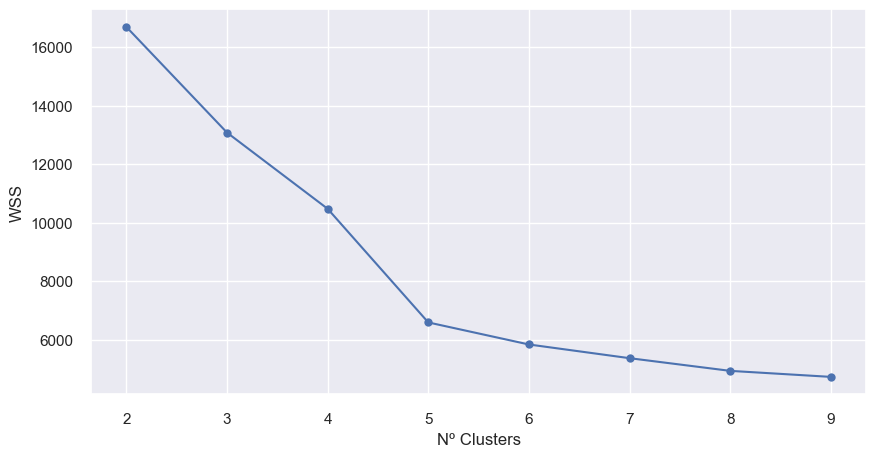

In [43]:
## Visualização performance(WSS) x nº cluster passados para algoritmo

fig, ax1 = plt.subplots(figsize = (10,5))

ax1.plot(clusters, wss, marker = 'o');

plt.xlabel("Nº Clusters");
plt.ylabel("WSS");

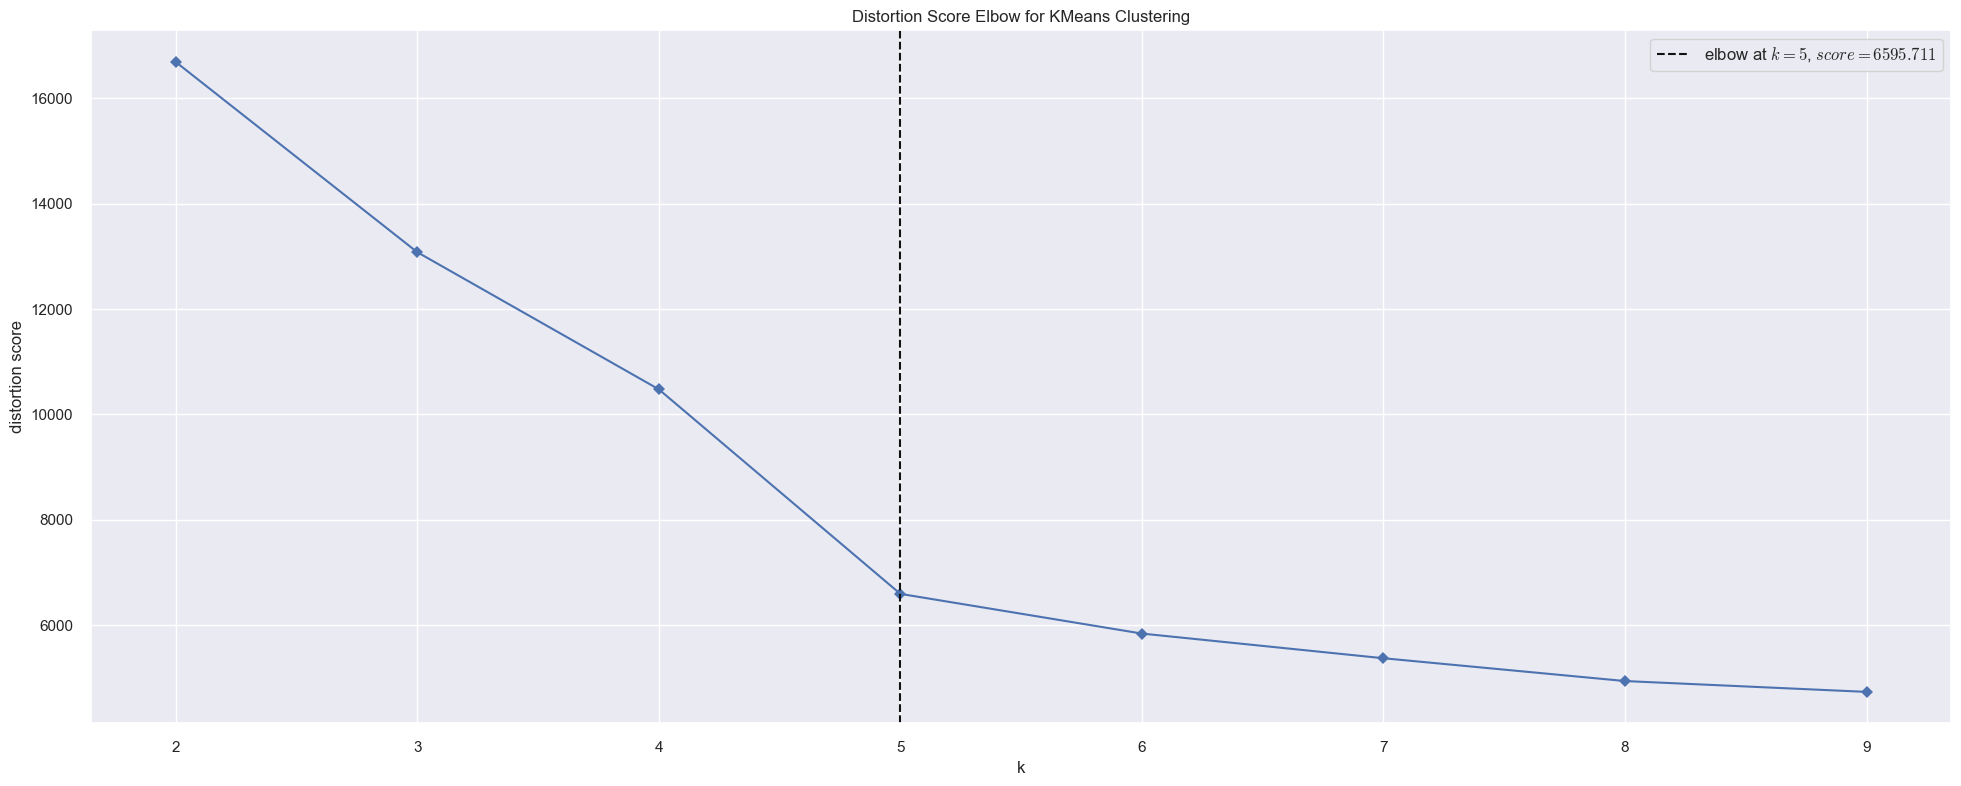

In [44]:
## Utilizando a biblioteca yellowbrick

k_means = KElbowVisualizer( ct.KMeans(init = 'random', n_clusters = k, n_init = 10, random_state = 42), k = clusters, timings = False );
k_means.fit( X );
k_means.show();

- Pela métrica WSS deveria escolher k = 5 , pois é a quantidade de cluster que faz com que a soma das distâncias dos centroídes de cada cluster com cada ponto ao quadrado resulte em um valor com considerável redução com relação a soma das distâncias dos cluster adjacentes. 

- Obviamente assumindo cluster maiores que 5 , o somatório das distâncias será menor pois irá obrigar o algoritmo a criar um novo centroíde, porém a redução de distâncias de cada ponto para o centroíde não é significativa ao ponto de justificar aumentar o número de clusters.

- Se a curva (elbow method) fosse mais suave, significa que a distribuição dos dados no espaço de features está bastante sobreposta (não há clusters naturais formados), não sendo possível a realização de agrupamentos consistentes. -> nesse caso, deve-se ajustar novo espaço de features.

## 7.2. Silhouette Score (SS)

In [45]:
ss = []

for k in clusters:
    
    # model definition 
    
    kmeans = ct.KMeans(init = 'random', n_clusters = k, n_init = 10, random_state = 42)
    
    # model fit 
    
    kmeans.fit( X )
    
    # performance 
    ss_avg = mt.silhouette_score(X, kmeans.labels_)
    ss.append( ss_avg )
    
    print(f"{k} cluster: {ss_avg}")

2 cluster: 0.8792779777222919
3 cluster: 0.5031590475612747
4 cluster: 0.5471085568975702
5 cluster: 0.5483545593942902
6 cluster: 0.5131717952560876
7 cluster: 0.43640013625284185
8 cluster: 0.43824918963653403
9 cluster: 0.3074185964827021


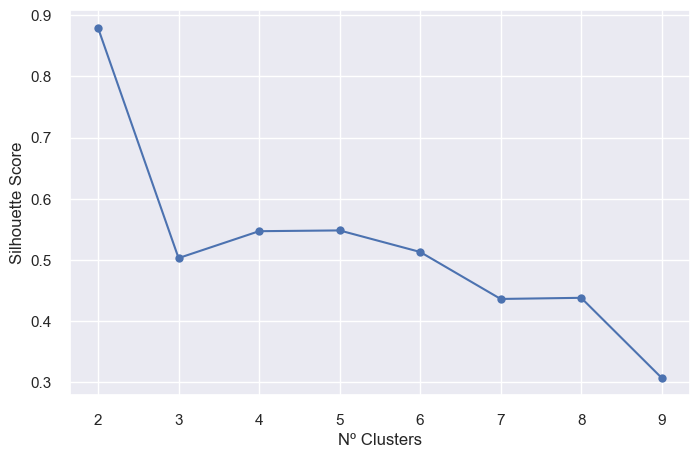

In [46]:
## Visualização performance(Silhouette Score Mean) x nº cluster passados para algoritmo

fig, ax1 = plt.subplots(figsize = (8,5))

ax1.plot(clusters, ss, marker = 'o');

plt.xlabel("Nº Clusters");
plt.ylabel("Silhouette Score");

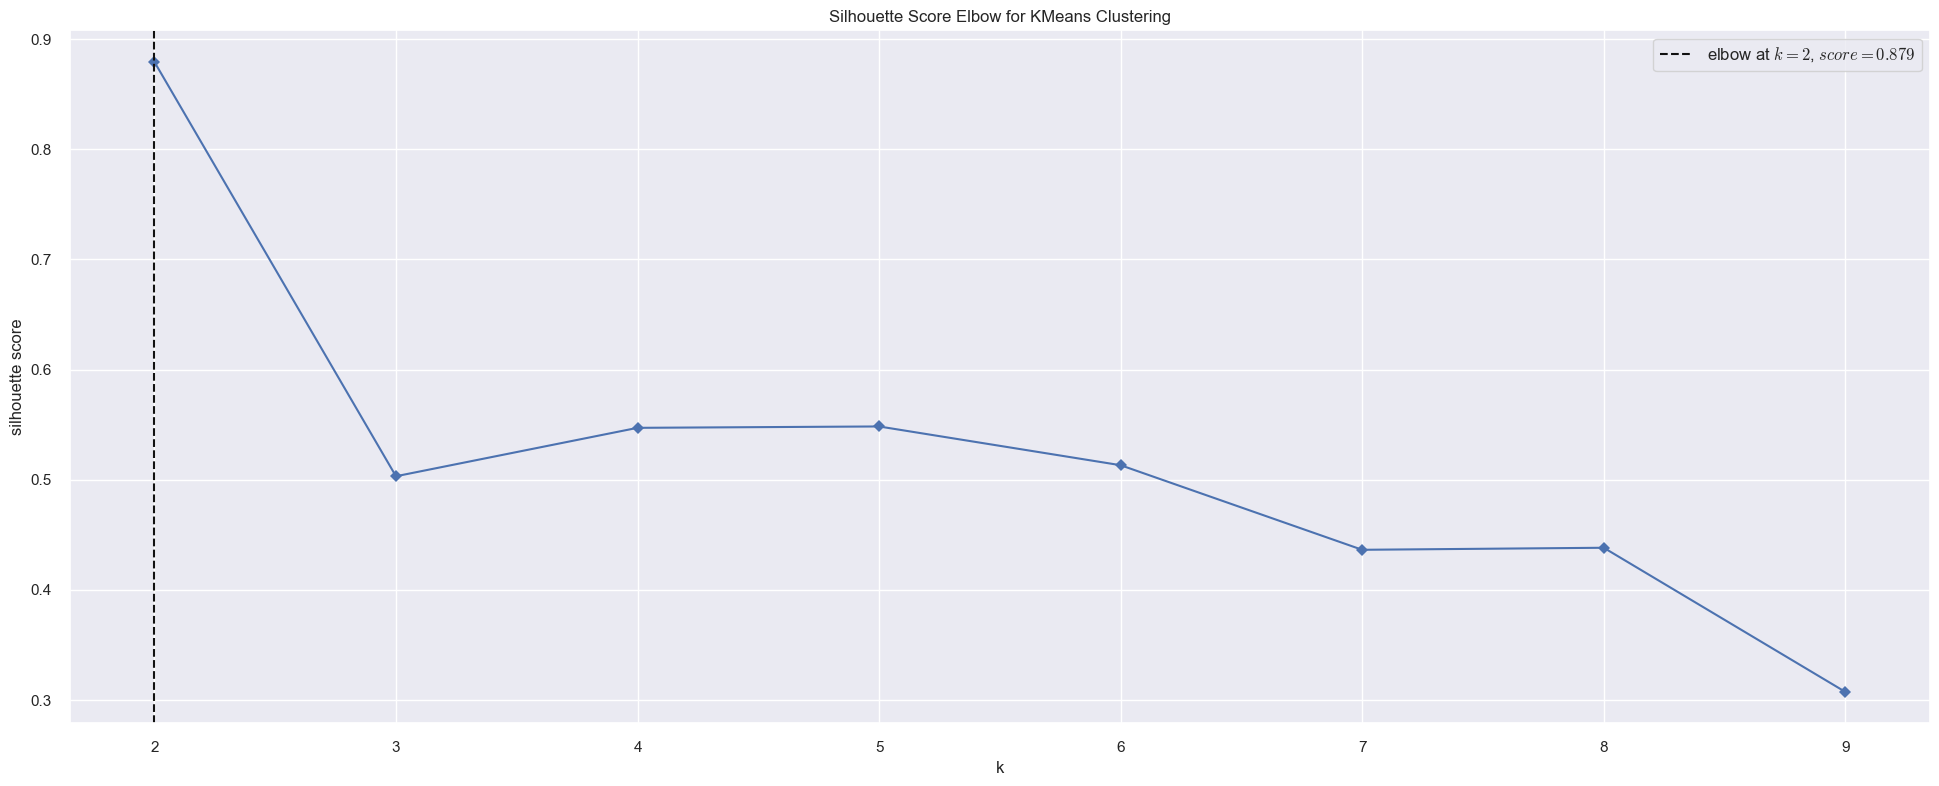

In [47]:
## Utilizando a biblioteca yellowbrick

k_means = KElbowVisualizer( ct.KMeans(init = 'random', n_clusters = k, n_init = 10, random_state = 42), k = clusters, metric = 'silhouette', timings = False );
k_means.fit( X );
k_means.show();

5 clusters já começa a ficar melhor que 3 e 4 

## 7.3. Silhouette Analysis

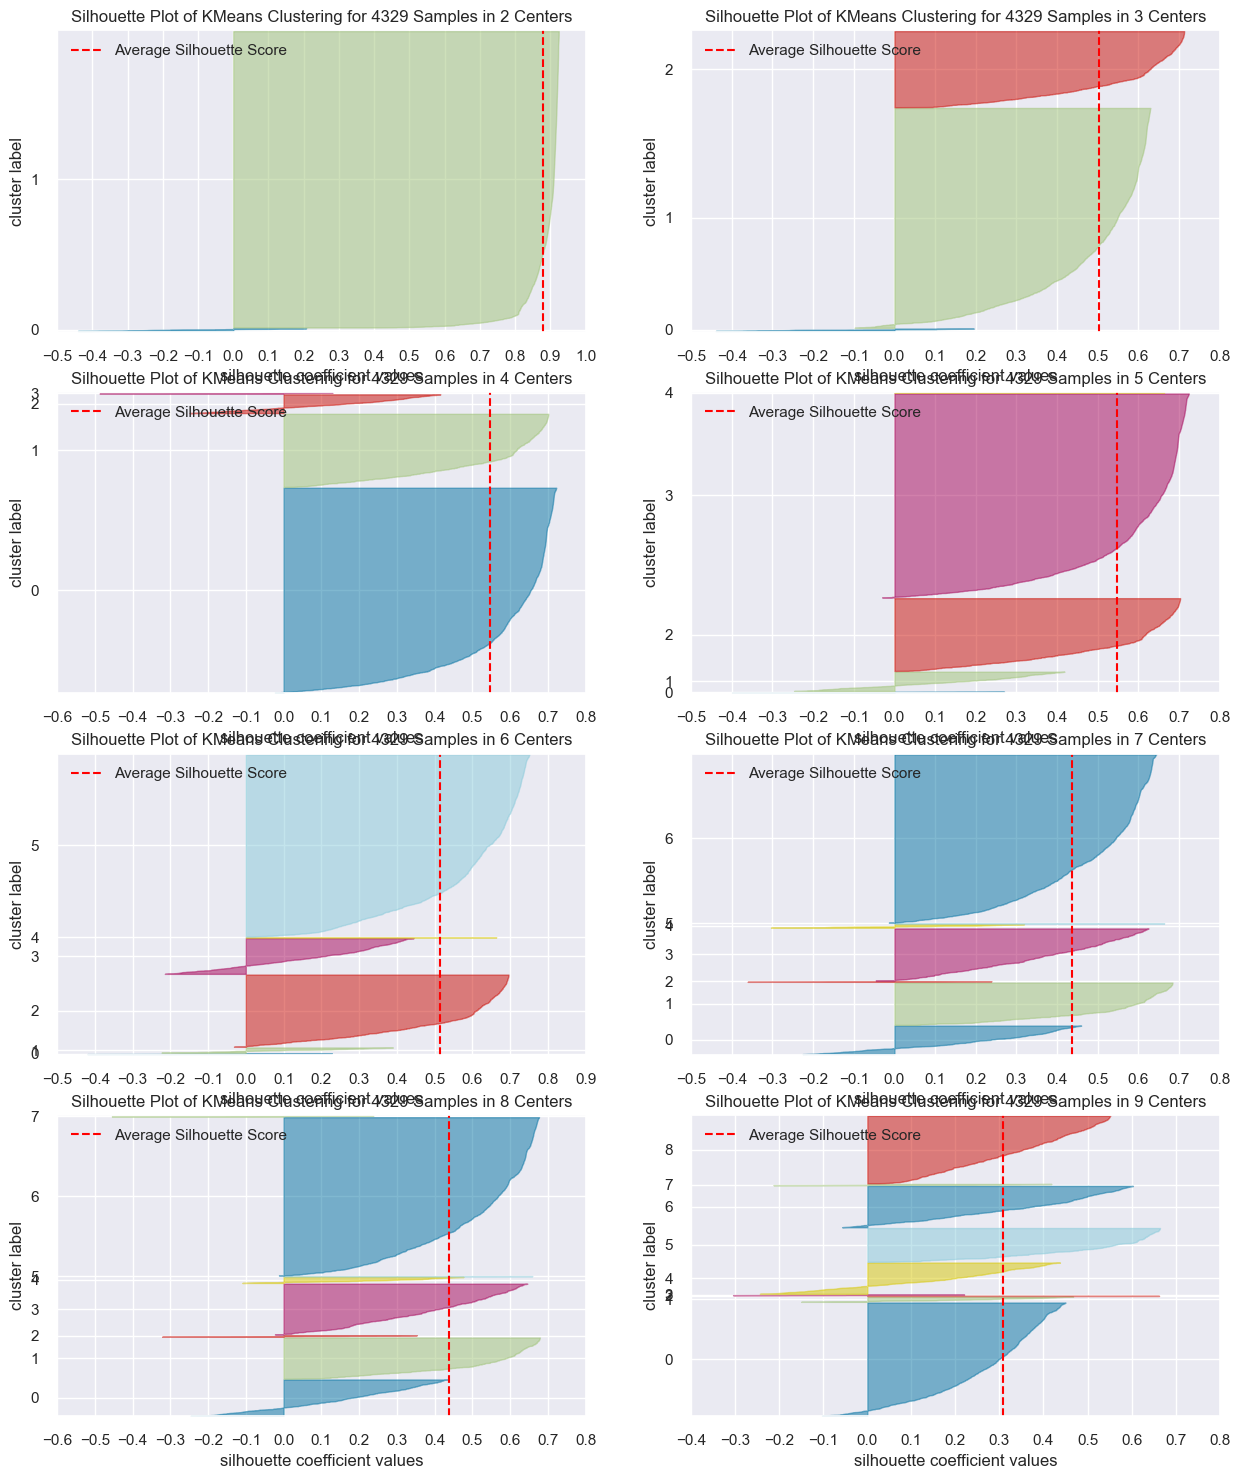

In [48]:
fig, ax = plt.subplots(4,2, figsize = (15,18))

for k in clusters:
    
    km = ct.KMeans( n_clusters=k, 
                        init='random', 
                        n_init=10, 
                        random_state=42 )
        
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax = ax[q-1, mod])
    visualizer.fit( X )
    visualizer.finalize()

Existe um cluster que possui a maioria das amostras ainda, mas a separação está ocorrendo melhor para mais clusters.

## 7.4. Conclusion

- Como adotou-se a métrica Silhouette Score para avaliação e ela é melhor para 2 clusters, entende-se que a melhor segmentação (+ coeso e separado) se dá com 2 clusters por enquanto. Contudo, o K-means será construído para clusterizar o conjunto de dados com 5 clusters.

#   8.0 Model Training 

## 8.1. K-means

In [49]:
# model definition 
k = 5
rs = 42

kmeans = ct.KMeans( n_clusters= k, 
                    init='random', 
                    n_init=10, 
                    max_iter=300,
                    random_state=rs )

# model fit 
kmeans.fit( X )

# clustering
labels = kmeans.labels_

In [50]:
## WSS (Within-Cluster Sum of Square)
print("WSS: {}".format(kmeans.inertia_))

## SS (Silhouette Score)
print("SS: {}".format( mt.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS: 6595.7111220045
SS: 0.5483545593942902


#  9.0 Cluster Analysis 


In [51]:
# Pegar o conjunto de dados antes e depois de fazer a normalização, padronização
df9_before = df4.copy()
df9_after = df7.copy()
df9_before['cluster'] = labels
df9_after['cluster'] = labels
df9_before.head()

,customer_id,gross_revenue,recency_days,purchases,avg_ticket,returns,cluster
0,17850,5391.210,372.000,34.000,18.152,1.000,2
1,13047,3232.590,56.000,9.000,18.904,7.000,1
2,12583,6705.380,2.000,15.000,28.902,2.000,1
3,13748,948.250,95.000,5.000,33.866,0.000,3
4,15100,876.000,333.000,3.000,292.000,3.000,2


In [52]:
df9_after.head()

,customer_id,gross_revenue,recency_days,purchases,avg_ticket,returns,cluster
0,17850,0.378,2.792,3.895,-0.034,0.115,2
1,13047,0.136,-0.361,0.622,-0.033,3.158,1
2,12583,0.525,-0.900,1.408,-0.027,0.622,1
3,13748,-0.121,0.028,0.098,-0.023,-0.393,3
4,15100,-0.129,2.403,-0.163,0.152,1.129,2


## 9.1. Visualization Inspection

Visualização dos cluster até 3 dimensões, se maior que 3, usar outras técnicas 

In [48]:
# fig = px.scatter_3d(df9, x = 'recency_days', y = 'frequency_total', z = 'gross_revenue_total', color = 'cluster')
# fig.show()

AttributeError: module 'plotly.validators.layout.template' has no attribute 'LayoutValidator'

In [56]:
## NÃO POSSO USAR MAIS A VISUALIZAÇÃO DOS DADOS POIS ALGORITMO ESTÁ CONSTRUÍDO COM 4 DIMENSÕES

# fig = go.Figure(data=[go.Scatter3d(x=df9['recency_days'], y=df9['frequency_total'], z=df9['gross_revenue_total'],
#                                    mode='markers', marker=dict(size=12,color=df9['cluster'],colorscale='Viridis', opacity=0.8))])
# fig.show()

## 9.2. Silhouette Analysis

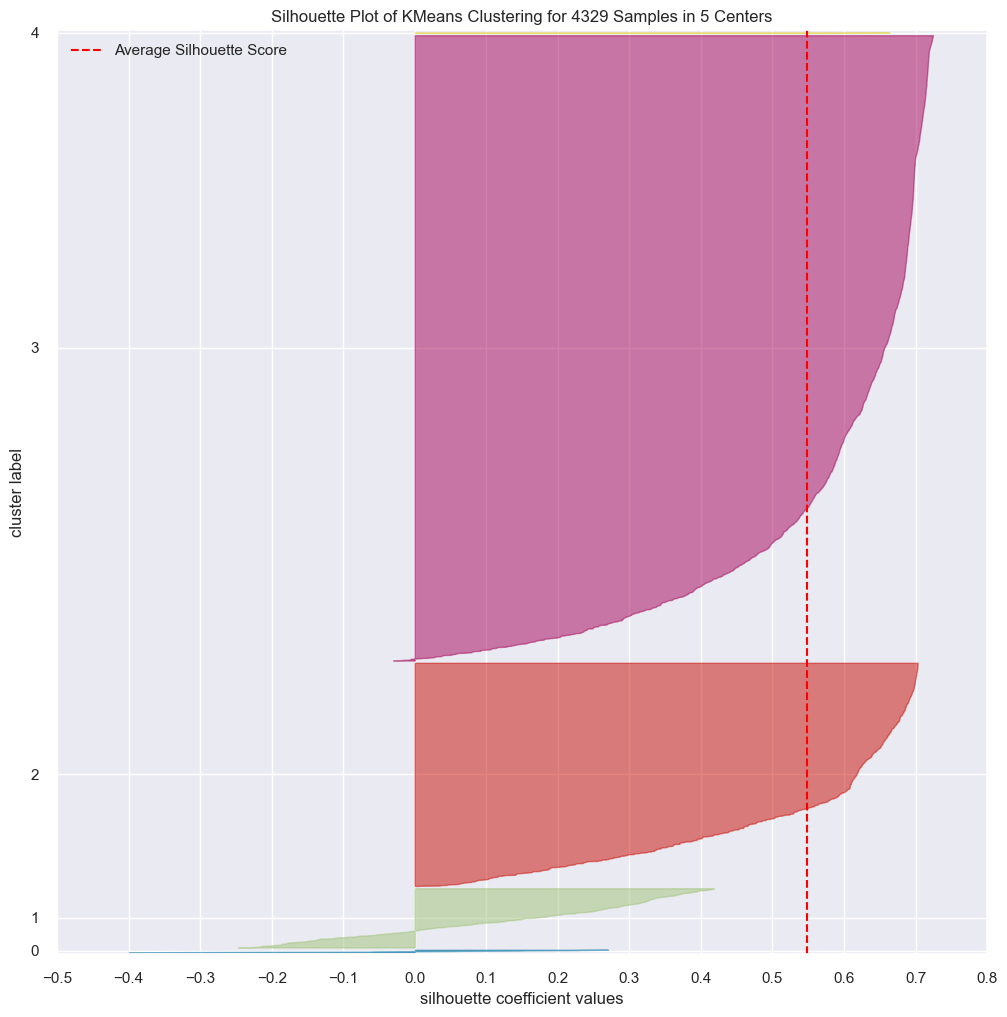

In [53]:
fig, ax1 = plt.subplots(figsize = (12,12))

kmeans = ct.KMeans( n_clusters= k,init='random', n_init=10, max_iter=300,random_state=rs )

visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax1)
visualizer.fit( X ) 
visualizer.finalize()

- Clusters 3, 1 e 0 possuem clientes (amostras) com coeficiente de silhueta menor que 0, o que significa que essas amostras não percentem ao cluster que lhe foi atribuído. Melhorar clusterização.

## 9.3. Pair plot 2d Features

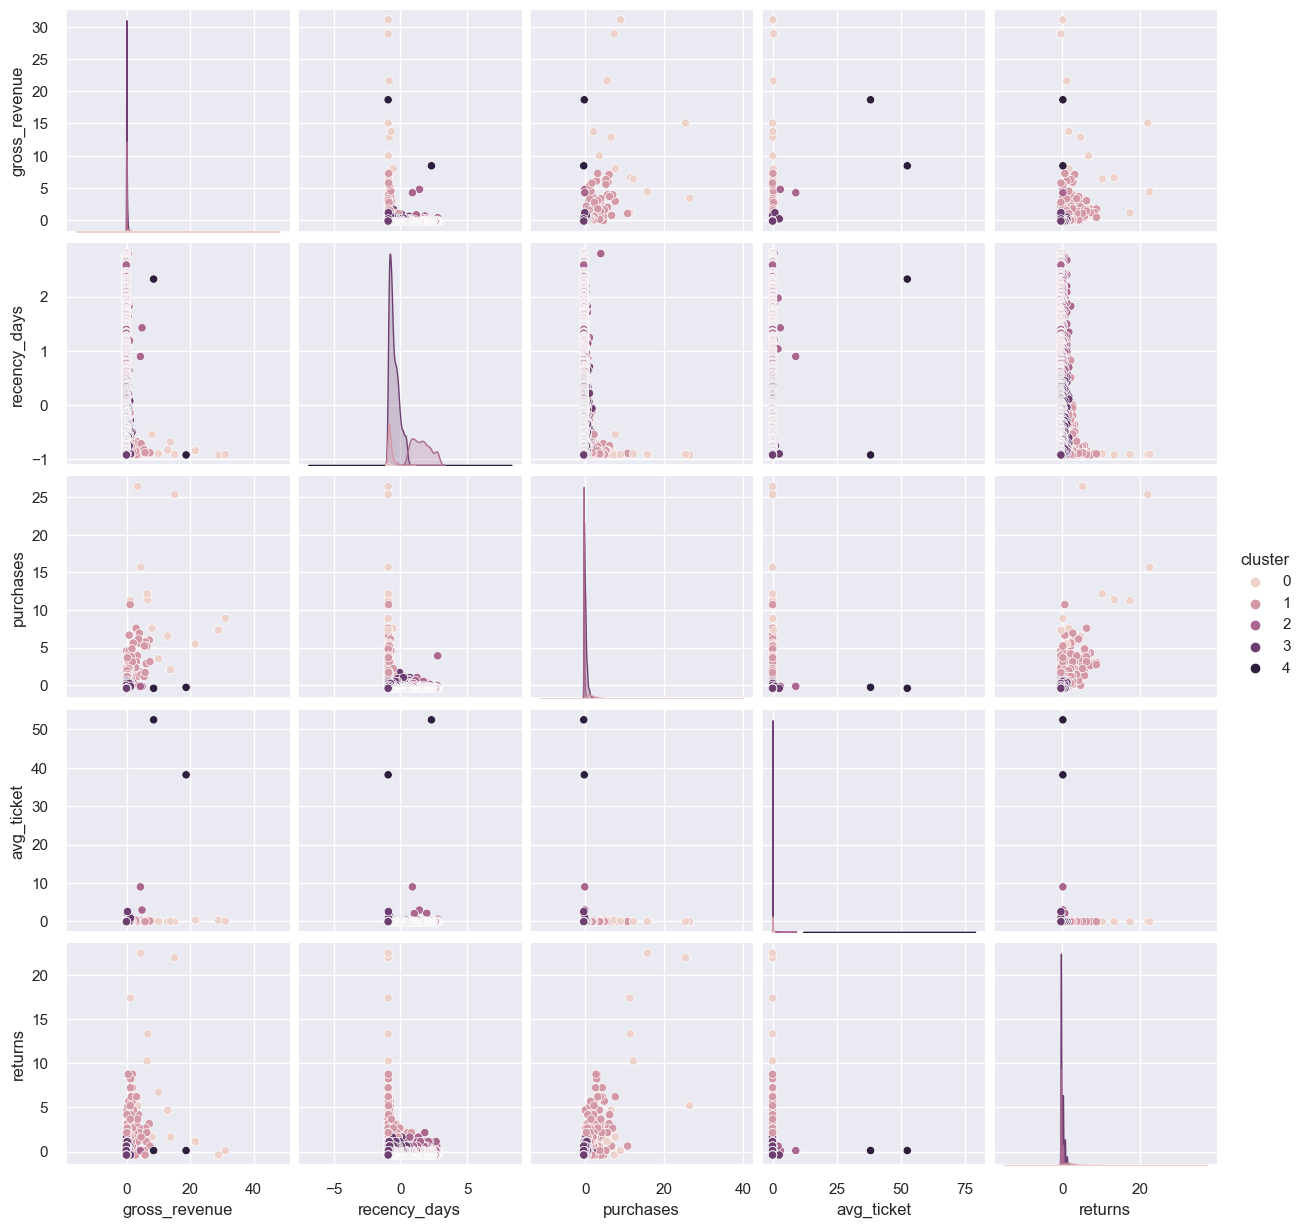

In [54]:
df_viz = df9_after.drop(columns = 'customer_id')

sns.pairplot(df_viz, hue = 'cluster');

Objetivo é avaliar as features que podem estar mais bagunçando do que auxiliando a criar grupos. O risco que se corre ao excluir features olhando apenas para essa visualização de cluster dois a dois é eliminar alguma feature pela aparente bagunça que causa misturada com apenas outra e ela ser uma feature relevante que em alta dimensionalidade cria clusters coesos e separados.

## 9.4. Redução de dimensionalidade com UMAP

In [55]:
## REDUÇÃO DE DIMENSIONALIDADE:

## Machine Learning - Manifold - Aprendizado por topologia
    ## Métodos UMAP - t-SNE 
## Machine Learning - Matrix - Espaço de distância - Espaço de Hilbert - 9 condições - Colorários
    ## Método PCA 

# reducer = projeção de alta dimensionalidade
reducer = umap.UMAP(random_state = 42)

# embedding = espaço projetado em 2D
embedding = reducer.fit_transform( X )

df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

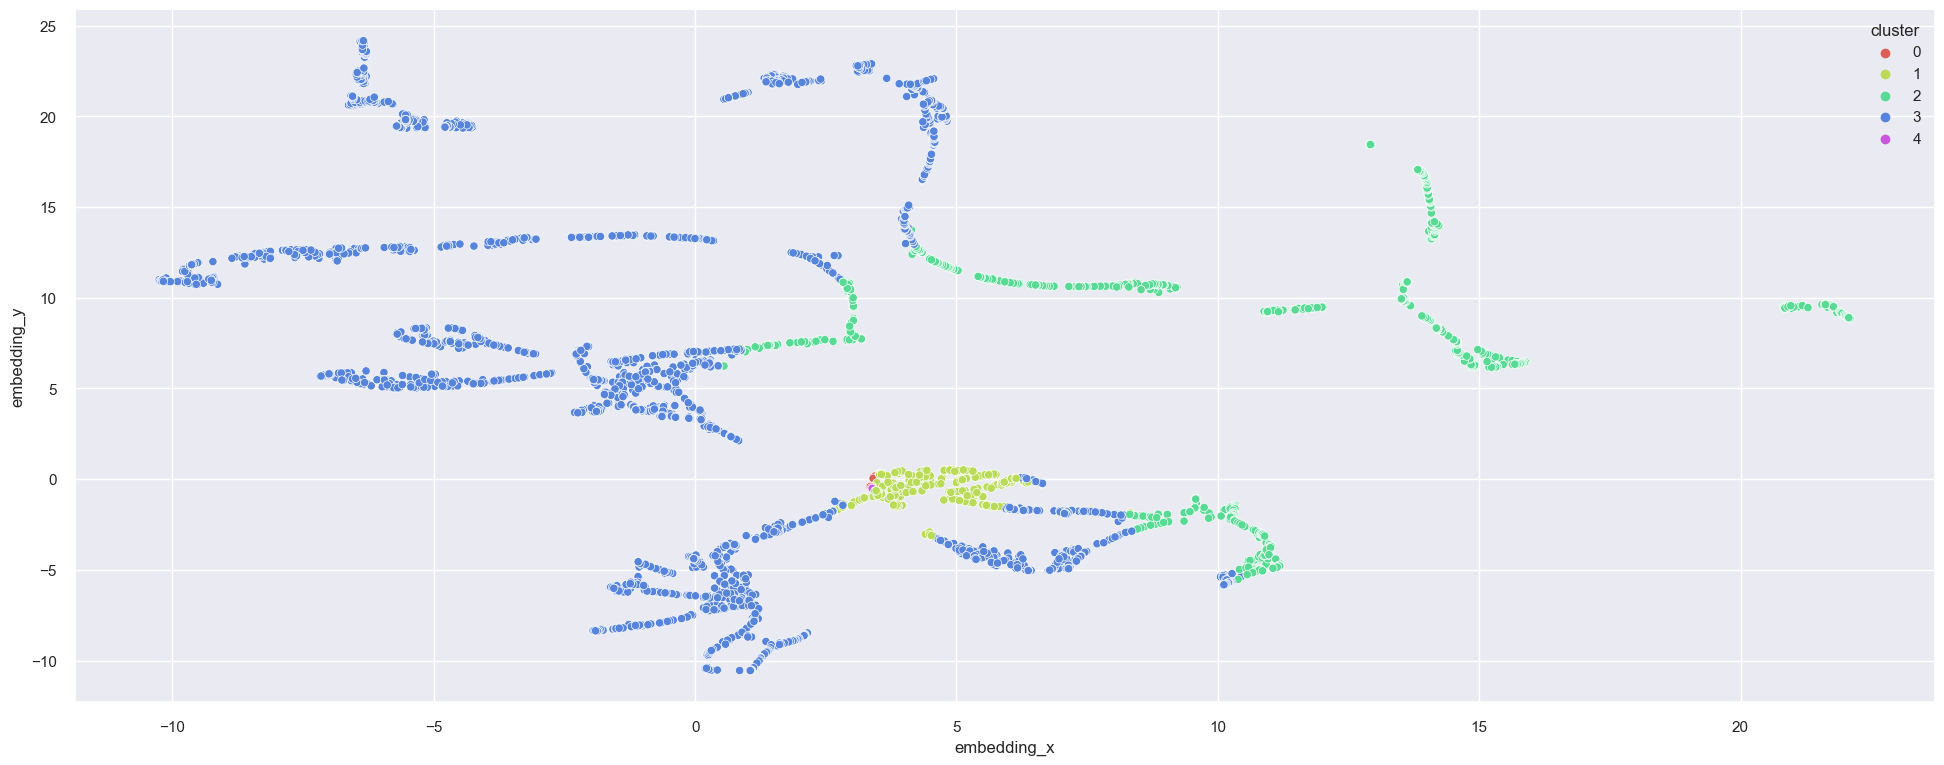

In [56]:
# plot embedding - clusters projetados de alta dimensionalidade

sns.scatterplot(x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette = sns.color_palette('hls', n_colors = df_viz['cluster'].nunique()),
                data = df_viz );

**Interpretação:** não significa que em alta dimensionalidade os cluster estão nessa distância um do outro, como é uma projeção, possui o intuito  de verificar se no espaço projetado existem cluster misturados, assim sendo, existe uma alta probabilidade de estarem também no espaço de alta dimensionalidade.

## 9.5. Cluster Profile

In [57]:
## Number of customer 

df_cluster = df9_before[['customer_id','cluster']].groupby(by = 'cluster').count().reset_index().rename(columns = {'customer_id':'n_customer'})
df_cluster['perc_customer'] = 100 * (df_cluster['n_customer'] / df_cluster['n_customer'].sum())


## Avg gross_revenue
df_reve = df9_before[['gross_revenue','cluster']].groupby(by = 'cluster').mean().reset_index().rename(columns = {'gross_revenue':'mean_revenue'})

## Avg recency_days 
df_rece = df9_before[['recency_days','cluster']].groupby(by = 'cluster').mean().reset_index().rename(columns = {'recency_days':'mean_recency_days'})

## Avg purchases
df_freq = df9_before[['purchases','cluster']].groupby(by = 'cluster').mean().reset_index().rename(columns = {'purchases':'mean_purchases'})

## avg_ticket 
df_ticket = df9_before[['avg_ticket','cluster']].groupby(by = 'cluster').mean().reset_index().rename(columns = {'avg_ticket':'mean_ticket'})

## Avg returns
df_return = df9_before[['returns','cluster']].groupby(by = 'cluster').mean().reset_index().rename(columns = {'returns':'mean_returns'})

## join tables
df_c_profile = df_cluster.merge(df_reve, on = 'cluster', how = 'left').merge(df_rece, on = 'cluster', how = 'left').merge(df_freq, on = 'cluster', how = 'left').merge(df_ticket, on = 'cluster', how = 'left').merge(df_return, on = 'cluster', how = 'left')

df_c_profile


,cluster,n_customer,perc_customer,mean_revenue,mean_recency_days,mean_purchases,mean_ticket,mean_returns
0,0,13,0.300,113826.606,6.692,88.538,159.240,16.846
1,1,282,6.514,9215.010,16.578,17.507,44.667,4.933
2,2,1061,24.509,555.168,248.767,1.558,55.956,0.272
3,3,2971,68.630,1293.899,43.762,3.584,29.307,0.488
4,4,2,0.046,122828.050,162.500,1.500,66670.550,1.000


<font color = 'red'> **Relatório:** </font> Não documentado conforme tabela pois resultado da clusterização não ficou satisfatório

### CLUSTER 0: (Candidato à Insiders)

        - Quantidade de clientes: 6 (0,14%)
        - Média de faturamento total gerado: US 182.181,9 
        - Média da recência: 7,167 dias
        - Média de transações no período total: 89 
        - Média do ticket médio: US 253,6

### CLUSTER 1:

        - Quantidade de clientes: 31 (0,71%)
        - Média de faturamento total gerado: US 40.543,5 
        - Média da recência: 13,3 dias
        - Média de transações no período total: 53,29
        - Média do ticket médio: US 201,9

### CLUSTER 2:

        - Quantidade de clientes: 4.335 (99,15%)
        - Média de faturamento total gerado: US 1.372,6 
        - Média da recência: 92,25 dias
        - Média de transações no período total: 4,6
        - Média do ticket médio: US 27,3

**Análise:**

- Quantidade de amostras em cada cluster muito desequilibrada

# <font color = 'red'>  10.0 Deploy to production </font>